# **Main functions and classes**

In [1]:
!pip install gym_2048

     |████████████████████████████████| 1.5MB 39.7MB/s 
     |████████████████████████████████| 13.8MB 231kB/s 
  Created wheel for gym-2048: filename=gym_2048-0.2.6-cp36-none-any.whl size=4682 sha256=bac061916e24fa503319961c2b5f3628e08a28408bdaf098517693ebff784ac6
  Stored in directory: /root/.cache/pip/wheels/ab/11/22/a6c0fb3622f6fad7e8b7f4342a3c64e115bee08a4189bbae18
  Created wheel for gym: filename=gym-0.10.11-cp36-none-any.whl size=1588313 sha256=e20c9f7845cb59f492b539ff7f4f9e956b10a32aea7813d4269e5158535b4f36
  Stored in directory: /root/.cache/pip/wheels/7b/eb/1f/22c4124f3c64943aa0646daf4612b1c1f00f27d89b81304ebd
Successfully built gym-2048 gym
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: spacy 2.1.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
import gym_2048
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Using cuda to accelerate training

In [0]:
class DQN(nn.Module):
    ### Deep Q-Learning Network
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv_a = nn.Conv2d(16, 128, kernel_size=(1,2))        # Convolutional layers
        self.conv_b = nn.Conv2d(16, 128, kernel_size=(2,1))

        self.conv_aa = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_ab = nn.Conv2d(128, 128, kernel_size=(2,1))

        self.conv_ba = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_bb = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        self.fc = nn.Sequential(         # Linear and Relu
            nn.Linear(7424, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        
    def forward(self, x):
      # Forward function of the layer
        x_a = F.relu(self.conv_a(x))
        x_b = F.relu(self.conv_b(x))
        
        x_aa = F.relu(self.conv_aa(x_a))
        x_ab = F.relu(self.conv_ab(x_a))
        
        x_ba = F.relu(self.conv_ba(x_b))
        x_bb = F.relu(self.conv_bb(x_b))
        
        sh_a = x_a.shape
        sh_aa = x_aa.shape
        sh_ab = x_ab.shape
        sh_b = x_b.shape
        sh_ba = x_ba.shape
        sh_bb = x_bb.shape
        
        x_a = x_a.view(sh_a[0],sh_a[1]*sh_a[2]*sh_a[3])
        x_aa = x_aa.view(sh_aa[0],sh_aa[1]*sh_aa[2]*sh_aa[3])
        x_ab = x_ab.view(sh_ab[0],sh_ab[1]*sh_ab[2]*sh_ab[3])
        x_b = x_b.view(sh_b[0],sh_b[1]*sh_b[2]*sh_b[3])
        x_ba = x_ba.view(sh_ba[0],sh_ba[1]*sh_ba[2]*sh_ba[3])
        x_bb = x_bb.view(sh_bb[0],sh_bb[1]*sh_bb[2]*sh_bb[3])
        
        concat = torch.cat((x_a,x_b,x_aa,x_ab,x_ba,x_bb),dim=1)
        
        output = self.fc(concat)
        
        return output

In [0]:
class Memory(object):
  ## Class for replay buffer
    def __init__(self, memory_size, array):
        self.memory_size = memory_size
        self.buffer = collections.deque(array, maxlen=self.memory_size)

    def add(self, experience):
      # Add to buffer
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
      ## Sample min(batch_size, len(buffer)) elements for buffer
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()

In [0]:
class Env(gym_2048.Base2048Env):
  ## Class inherits from base 2048 environment

    metadata = {
      'render.modes': ['human'], 'rewards':['score','nb_merge', 'nb_merge_max_tile', 'nb_empty_tiles']
  }

    def __init__(self, reward_mode = 'score'):
      super().__init__()
      self.reward_mode = reward_mode  # Several reward modes
    
    def step(self, action: int): 

        # Align board action with left action
        rotated_obs = np.rot90(self.board, k=action)
        reward, updated_obs = self._slide_left_and_merge(rotated_obs)
        self.board = np.rot90(updated_obs, k=4 - action)

        # Place one random tile on empty location
        self._place_random_tiles(self.board, count=1)

        done = self.is_done()

        return self.board, reward, done, {}

    def _slide_left_and_merge(self, board):
        ## Slides the board to the left
        result = []

        score = 0
        max_tile = 0 # Maximum value in the board
        for row in board:
          row = np.extract(row > 0, row)
          score_, max_row, result_row = self._try_merge(row)
          max_tile = max(max_tile, max_row)  
          score += score_
          row = np.pad(np.array(result_row), (0, 4 - len(result_row)),
                      'constant', constant_values=(0,))
          result.append(row)
        
        
        score = score + int(self.reward_mode == 'nb_merge_max_tile')*np.log2(max_tile)  # Different cases of rewards
        return score, np.array(result, dtype=np.int64)

    
    def _try_merge(self,row):
        # Merging tiles
        score = 0
        result_row = []

        i = 1
        max_row = 0
        while i < len(row):
          if row[i] == row[i - 1]:
            # If equal tiles, merge
            score += (row[i] + row[i - 1])*int(self.reward_mode == 'score') + int(self.reward_mode != 'score')
            max_row = max(max_row, row[i] + row[i - 1]) 
            result_row.append(row[i] + row[i - 1])
            i += 2
          else:
            max_row = max(max_row, row[i - 1])
            result_row.append(row[i - 1])
            i += 1
          

        if i == len(row):
          max_row = max(max_row, row[i - 1])
          result_row.append(row[i - 1])

        score = score*int(self.reward_mode != 'nb_empty_tiles') + (4-len(row))*int(self.reward_mode == 'nb_empty_tiles')  # (4 - len(row)) empty tiles in the row
      
        return score, max_row, result_row


In [0]:
def change_values(X):
    # Transform input of the DQN (normalization)
    power_mat = np.zeros(shape=(1,16,4,4),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][0][i][j] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][power][i][j] = 1.0
    return power_mat 

In [0]:
import time 



def training(n_epochs, reward_mode, online_dic, target_dic, epsilon, memory_buffer, opti, path = "/content/gdrive/My Drive/2048/", cont = True, print_rate = 100):             
    # Training the agent (we input parameters coming from previous training)
    
    GAMMA = 0.99 
    EXPLORE = 10000
    INITIAL_EPSILON = 0.1
    FINAL_EPSILON = 0.0001
    REPLAY_MEMORY = 50000   # Size of replay buffer
    BATCH = 16  # Length of batch extracted from buffer


    UPDATE_STEPS = 4
    
    begin_learn = False
    learn_steps = 0
    episode_reward = 0
    scores = []
    max_tiles = []
      
    env = Env(reward_mode = reward_mode)
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    if cont:
      ## In this case, we load previous training parameters to continue the training
        epsilon = np.float(np.load(path+epsilon))
        memory_replay = Memory(REPLAY_MEMORY, collections.deque(np.load(path+memory_buffer, allow_pickle = True)))

        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        onlineQNetwork.load_state_dict(torch.load(path+online_dic))
        targetQNetwork.load_state_dict(torch.load(path+target_dic))
        
        optimizer = torch.load(path + opti)
        
    else:
      ## Start of the training

        epsilon = INITIAL_EPSILON
        memory_replay = Memory(REPLAY_MEMORY, np.array([]))
        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

        optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)
      
      
    
    for epoch in range(n_epochs):
          
        state = env.reset()
        episode_reward = 0
        done = False
          
        while not done:
              
            x = change_values(state)
            x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
              
            
            # Epsilon-greedy approach for the policy
            if random.random() < epsilon:
                action = random.randint(0,3)
                next_state, reward, done, _ = env.step(action)
                while (state == next_state).all():
                    action = random.randint(0,3)
                    next_state, reward, done, _ = env.step(action)             
            else:
                output = onlineQNetwork.forward(x) 
                for action in output.argsort()[0].cpu().numpy()[::-1]:
                    next_state, reward, done, _ = env.step(action)
                    if (state == next_state).all() == False:
                        break

              
            episode_reward += reward
            memory_replay.add((change_values(state), change_values(next_state), action, reward, done))  ## Adding data to the replay buffer
              
            if memory_replay.size() > 128:
                if begin_learn is False:
                    print('learn begin!')
                    begin_learn = True
                learn_steps += 1
                if learn_steps % UPDATE_STEPS == 0:
                    targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
                batch = memory_replay.sample(BATCH)
                batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).squeeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).squeeze(1).to(device)
                batch_action = torch.Tensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.Tensor(batch_reward).unsqueeze(1).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                with torch.no_grad():
                    targetQ_next = targetQNetwork(batch_next_state)
                    y = batch_reward + (1 - batch_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0]      # Q-learning update

                loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epsilon > FINAL_EPSILON:
                    epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
                      
            state = next_state
          
        scores.append(episode_reward)
        max_tiles.append(np.max(state))
              
        
        if epoch % print_rate == 0:
            env.render()
            #save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 0, 0, final = False)  #Uncomment to save data (not useful if you punctually train the agent)
            print("Game "+str(epoch)+", Episode reward: "+str(episode_reward))

    return(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay)

In [0]:
def save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, reward, run, path = "/content/gdrive/My Drive/2048/", final = True):
  ## Saves data in drive (previously mounted)
  if final:
    suffix = '_reward'+str(reward)+'_run' + str(run)
  else: 
    suffix = ''

  torch.save(onlineQNetwork.state_dict(), path + "online"+suffix)
  torch.save(targetQNetwork.state_dict(), path+ 'target' + suffix)
  torch.save(optimizer,path+'opti'+ suffix)
  np.save(path+'scores' + suffix, scores)
  np.save(path+'max_tiles' + suffix, max_tiles)
  np.save(path+'eps' + suffix, epsilon)
  np.save(path+'mem' + suffix, np.array(memory_replay.buffer))
  return()


# **Training agents for different rewards**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'nb_merge_max_tile', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 3, 1)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'scores', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 1)

16 	8 	4 	2
2 	4 	8 	4
4 	16 	2 	8
2 	64 	16 	2
Game 0, Episode reward: 375.0
learn begin!
4 	8 	16 	2
8 	4 	32 	128
4 	32 	128 	8
2 	4 	64 	2
Game 100, Episode reward: 1366.0
2 	4 	8 	16
4 	8 	16 	32
8 	16 	32 	64
16 	32 	2 	128
Game 200, Episode reward: 1186.0
2 	32 	16 	2
128 	4 	2 	16
4 	32 	8 	4
32 	8 	4 	2
Game 300, Episode reward: 836.0
4 	2 	4 	8
8 	4 	16 	4
32 	16 	64 	16
2 	256 	4 	2
Game 400, Episode reward: 1276.0
4 	2 	4 	8
2 	4 	8 	16
4 	8 	16 	2
8 	32 	2 	32
Game 500, Episode reward: 328.0
2 	4 	8 	16
16 	32 	16 	8
4 	16 	32 	64
8 	2 	64 	128
Game 600, Episode reward: 1299.0
8 	4 	2 	4
4 	8 	4 	32
8 	16 	64 	128
32 	2 	128 	256
Game 700, Episode reward: 2493.0
4 	2 	4 	2
32 	8 	64 	8
4 	16 	128 	32
8 	32 	64 	2
Game 800, Episode reward: 1212.0
4 	8 	16 	4
2 	4 	8 	32
4 	8 	32 	64
16 	32 	64 	256
Game 900, Episode reward: 1788.0
4 	2 	8 	2
16 	32 	16 	8
8 	16 	4 	128
16 	64 	128 	256
Game 1000, Episode reward: 2444.0
2 	4 	2 	8
4 	2 	8 	32
2 	4 	32 	64
8 	16 	64 	128
Game

In [0]:
#Due to failure of the training for the 'score' reward after 2601 games, we continue the training (parameter cont = True)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(399, 'score', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = True, print_rate = 50)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 2)  # Parameter 2 for 2nd run

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


learn begin!
8 	2 	4 	2
16 	4 	2 	4
32 	16 	4 	2
256 	32 	8 	4
Game 0, Episode reward: 2140.0
2 	8 	4 	2
8 	64 	16 	4
16 	32 	256 	16
256 	1024 	512 	4
Game 50, Episode reward: 17156.0
8 	2 	4 	2
4 	32 	8 	4
64 	16 	2 	8
4 	128 	64 	16
Game 100, Episode reward: 1636.0
4 	8 	4 	2
8 	32 	8 	16
16 	64 	16 	128
32 	512 	128 	4
Game 150, Episode reward: 6208.0
4 	8 	4 	2
2 	4 	32 	4
64 	128 	64 	32
128 	256 	2 	64
Game 200, Episode reward: 4428.0
4 	2 	4 	2
8 	4 	2 	4
32 	64 	8 	2
256 	512 	256 	128
Game 250, Episode reward: 8672.0
4 	2 	4 	2
8 	4 	2 	4
16 	32 	16 	2
1024 	256 	128 	32
Game 300, Episode reward: 11856.0
4 	2 	4 	2
2 	32 	8 	64
64 	128 	32 	16
512 	1024 	512 	128
Game 350, Episode reward: 19476.0


()

In [0]:
# Training for reward 3 (was run in another notebook)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, 'nb_empty_tiles', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 10)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 4, 1)  

## **Training results**

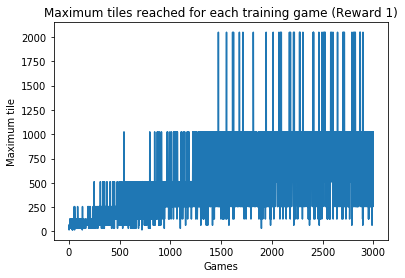

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix1 = "_reward1_run1.npy"
suffix2 = "_reward1_run2.npy"
scores_1 = np.concatenate((np.load(path+ "scores" + suffix1),np.load(path+ "scores" + suffix2)))
max_tiles_1 = np.concatenate((np.load(path+ "max_tiles" + suffix1),np.load(path+ "max_tiles" + suffix2)))
plt.plot(max_tiles_1)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 1)')
plt.show()

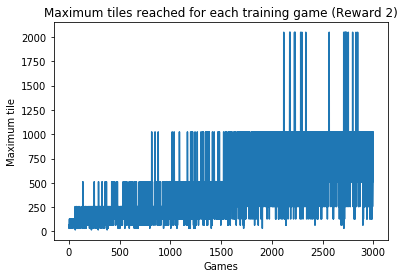

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix = "_reward3_run1.npy"
scores_3 = np.load(path+ "scores" + suffix)
max_tiles_3 = np.load(path+"max_tiles" + suffix)
plt.plot(max_tiles_3)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 2)')
plt.show()

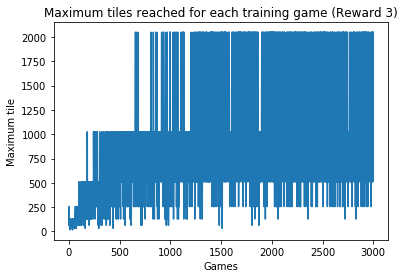

In [0]:
path = "/content/gdrive/My Drive/2048/"
suffix1 = "_reward4_run1.npy"
suffix2 = "_reward4_run3.npy"
scores_4 = np.concatenate((np.load(path+ "scores" + suffix1),np.load(path+ "scores" + suffix2)))
max_tiles_4 = np.concatenate((np.load(path+ "max_tiles" + suffix1),np.load(path+ "max_tiles" + suffix2)))
plt.plot(max_tiles_4)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 3)')
plt.show()

Text(0.5, 1.0, 'Reward training curve for reward 3 (moving average)')

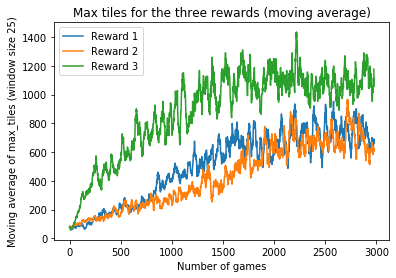

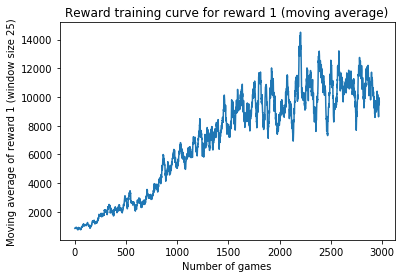

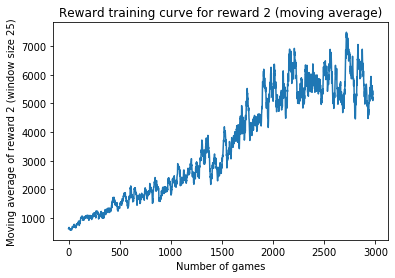

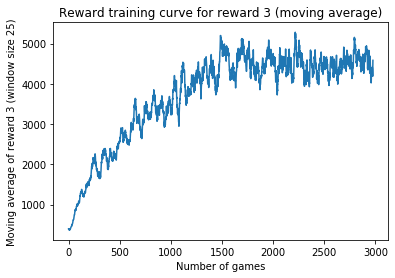

In [0]:
def moving_average(a, wind=25) :
    # Returns the moving average array associated to a with a window wind
    ret = np.cumsum(a, dtype=float)
    ret[wind:] = ret[wind:] - ret[:-wind]
    return ret[wind - 1:] / wind


plt.figure(0)
plt.xlabel('Number of games')
plt.ylabel('Moving average of max_tiles (window size 25)')
plt.plot(moving_average(max_tiles_1), label = 'Reward 1')
plt.plot(moving_average(max_tiles_3), label = 'Reward 2')
plt.plot(moving_average(max_tiles_4), label = 'Reward 3')
plt.legend(loc = 'best')

plt.title('Max tiles for the three rewards (moving average)')


plt.figure(1)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 1 (window size 25)')
plt.plot(moving_average(scores_1))
plt.title('Reward training curve for reward 1 (moving average)')

plt.figure(2)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 2 (window size 25)')
plt.plot(moving_average(scores_3))
plt.title('Reward training curve for reward 2 (moving average)')

plt.figure(3)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 3 (window size 25)')
plt.plot(moving_average(scores_4))
plt.title('Reward training curve for reward 3 (moving average)')

## **Testing results**

In [0]:
def play_game(env, QNetwork, render = True):
    ## Plays one unique game given an environment and a trained DQN
    state = env.reset()
    episode_reward = 0
    done = False
        
    while not done:
            
        x = change_values(state)
        x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
        output = QNetwork.forward(x) 
        for action in output.argsort()[0].cpu().numpy()[::-1]:
             next_state, reward, done, _ = env.step(action)
             if (state == next_state).all() == False:
                     break

            
        episode_reward += reward
        state = next_state
            
    if render:    
      env.render()         
      print( "Score: "+str(episode_reward))

    return(state)

def results(reward_mode):
    # Displays results (proportions of games reaching each existing level of max_tile) given a reward_mode
    if reward_mode == 'nb_merge_max_tile':
      reward_num = 3
      run = 1
    elif reward_mode == 'score':
      reward_num = 1
      run = 2
    elif reward_mode == 'nb_empty_tiles':
      reward_num = 4
      run = 3

    test_env = Env(reward_mode = reward_mode)

    path = "/content/gdrive/My Drive/2048/"
    QNetwork = DQN().to(device)
    filename = 'online_reward' + str(reward_num)+ '_run' + str(run)
    QNetwork.load_state_dict(torch.load(path + filename))
    
    dic_max = {}
    for i in range(13):
      dic_max[2**i]=0

    n_games = 1000

    for k in range(n_games):
      if (k%50 == 0):
        print(str(k) + " games played ")
      grid = play_game(test_env, QNetwork, render = False)
      max_tile = np.max(grid)
      dic_max[max_tile]=dic_max[max_tile]+1

    for key in dic_max:
      dic_max[key] = dic_max[key]/n_games

    return(dic_max)



In [0]:
results('nb_merge_max_tile')

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.0,
 64: 0.009,
 128: 0.033,
 256: 0.144,
 512: 0.409,
 1024: 0.381,
 2048: 0.024,
 4096: 0.0}

In [0]:
results('score')

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.0,
 64: 0.003,
 128: 0.029,
 256: 0.13,
 512: 0.339,
 1024: 0.454,
 2048: 0.045,
 4096: 0.0}

In [0]:
results('nb_empty_tiles')

0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.001,
 64: 0.002,
 128: 0.01,
 256: 0.039,
 512: 0.194,
 1024: 0.525,
 2048: 0.227,
 4096: 0.002}

# **Reproduce training results for each reward mode**

In [0]:
# This cell can reproduce the results obtained in the report: reward can be changed, n_epochs too (but will give different results if changed...)7
# For this number of epochs, run time is approximately 5 hours

def moving_average(a, wind=25) :
    # Returns the moving average array associated to a with a window wind
    ret = np.cumsum(a, dtype=float)
    ret[wind:] = ret[wind:] - ret[:-wind]
    return ret[wind - 1:] / wind

reward = 1          # Values can be 1,2 or 3
reward_mode = 'scores'*int(reward==1) + 'nb_merge_max_tile'*(int(reward == 2)) + 'nb_empty_tiles'*int(reward==3)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(3000, reward_mode, None, None,None, None, None, cont = False, print_rate = 100)

plt.figure(0)
plt.plot(max_tiles)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward ' + str(reward) + ')' )
plt.show()

plt.figure(1)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward ' + str(reward) + ' (window size 25)')
plt.plot(moving_average(scores))
plt.title('Reward training curve for reward ' + str(reward) + ' (moving average)')

plt.figure(2)
plt.xlabel('Number of games')
plt.ylabel('Moving average of max_tiles for reward ' + str(reward) + ' (window size 25)')
plt.plot(moving_average(max_tiles))
plt.title('Max tiles for reward ' + str(reward) + ' (moving average)')

plt.show()

# **Reproduce testing results for each reward mode**

In [0]:
def play_game(env, QNetwork, render = True):
    ## Plays one unique game given an environment and a trained DQN
    state = env.reset()
    episode_reward = 0
    done = False
        
    while not done:
            
        x = change_values(state)
        x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
        output = QNetwork.forward(x) 
        for action in output.argsort()[0].cpu().numpy()[::-1]:
             next_state, reward, done, _ = env.step(action)
             if (state == next_state).all() == False:
                     break

            
        episode_reward += reward
        state = next_state
            
    if render:    
      env.render()         
      print( "Score: "+str(episode_reward))

    return(state)

def testing_results(reward):
  ## Returns test results given a reward (1,2 or 3)
    reward_mode = 'scores' * int(reward == 1) + 'nb_merge_max_tile' * int(reward == 2) + 'nb_empty_tiles' * int(reward == 3)
    test_env = Env(reward_mode=reward_mode)

    QNetwork = DQN().to(device)
    filename = 'parameters_reward_' + str(reward) + '.dms'
    QNetwork.load_state_dict(torch.load(filename))

    dic_max = {}
    for i in range(13):
        dic_max[2 ** i] = 0

    n_games = 1000

    for k in range(n_games):
        if (k % 50 == 0):
            print(str(k) + " games played ")
        grid = play_game(test_env, QNetwork, render=False)
        max_tile = np.max(grid)
        dic_max[max_tile] = dic_max[max_tile] + 1

    for key in dic_max:
        dic_max[key] = dic_max[key] / n_games

    return (dic_max)

testing_results(1) # Parameter can be from 1 to 3